## Importing the modules

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandasql import *
from sqlalchemy import create_engine
plt.style.use("ggplot")
import timeit

%matplotlib inline

# constants and variable

In [2]:
# Create your engine.
engine = create_engine('sqlite:///:memory:')

# Set up datasets

First, the data is read into a dataframe. Next, we transform it into a sql table. Finally, the data is read into a sql data-table.

In [3]:
df1 = pd.read_csv("./data/Master.csv",sep=",")
df1.to_sql("Master",engine)

df2 = pd.read_csv("./data/Salaries.csv",sep=",")
df2.to_sql("Salaries",engine)

df3 = pd.read_csv("./data/Teams.csv",sep=",")
df3.to_sql("Teams",engine)


In [4]:
with engine.connect() as conn, conn.begin():
    df_Master = pd.read_sql_table('Master', conn)
    df_Salaries= pd.read_sql_table('Salaries',conn)
    df_Teams = pd.read_sql_table('Teams',conn)

## Joining the Salary and Master dataframes

In [8]:
q = """
    SELECT
        m.playerID
        , s.salary
        , m.nameFirst
        , m.nameLast
        
    FROM
        df_Master m
    INNER JOIN
        df_Salaries s
            on m.playerID = s.playerID
    ORDER BY
        s.playerID
    ;
    """

joined = sqldf(q,globals())


In [9]:
joined["cummulativeSalary"] = joined.groupby("playerID").cumsum()

In [12]:
joined.head()

,playerID,salary,nameFirst,nameLast,cummulativeSalary
0,aardsda01,300000,David,Aardsma,300000
1,aardsda01,387500,David,Aardsma,687500
2,aardsda01,403250,David,Aardsma,1090750
3,aardsda01,419000,David,Aardsma,1509750
4,aardsda01,500000,David,Aardsma,2009750


## Ron Gant's Salary

In [23]:
Ron_Gant_df = joined[(joined.nameFirst =="Ron") & (joined.nameLast =="Gant")][["salary",
                                                                               "cummulativeSalary"]].reset_index(drop= True)
Ron_Gant_df

,salary,cummulativeSalary
0,65000,65000
1,109000,174000
2,125000,299000
3,350000,649000
4,500000,1149000
5,1195000,2344000
6,1750000,4094000
7,2700000,6794000
8,3633335,10427335
9,3700000,14127335


## “Curtis Granderson” and “Reggie Sanders”

In [24]:
Curtis_Granderson_df = joined[(joined.nameFirst == "Curtis") & (joined.nameLast == "Granderson")][["salary",
                                                                               "cummulativeSalary"]].reset_index(drop= True)
Curtis_Granderson_df

,salary,cummulativeSalary
0,335000,335000
1,410000,745000
2,1000000,1745000
3,3500000,5245000
4,5500000,10745000
5,8250000,18995000
6,10000000,28995000
7,13000000,41995000
8,15000000,56995000
9,16000000,72995000


In [25]:
Reggie_Sanders_df = joined[(joined.nameFirst == "Reggie") & (joined.nameLast == "Sanders")][["salary",
                                                                               "cummulativeSalary"]].reset_index(drop= True)
Reggie_Sanders_df

,salary,cummulativeSalary
0,109000,109000
1,275000,384000
2,925000,1309000
3,1000000,2309000
4,1500000,3809000
5,1750000,5559000
6,1975000,7534000
7,2000000,9534000
8,3575000,13109000
9,3700000,16809000


# Cumulative Salaries

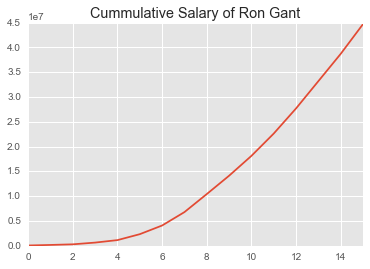

In [27]:
Ron_Gant_df.cummulativeSalary.plot(title = "Cummulative Salary of Ron Gant")

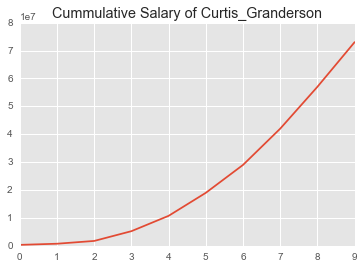

In [28]:
Curtis_Granderson_df.cummulativeSalary.plot(title = "Cummulative Salary of Curtis_Granderson")

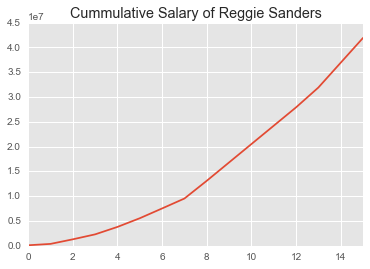

In [29]:
Reggie_Sanders_df.cummulativeSalary.plot(title = "Cummulative Salary of Reggie Sanders")

# New York Yankees with over 90 wins

### Solution Based on SQL Query

In [60]:
#%%timeit
q = """
    SELECT
        t.W
        , t.name

    FROM
        df_Teams t
    WHERE
        t.W > 90
    AND
        t.name == 'New York Yankees'

    """

df_NYY_90_a = sqldf(q,globals())
print("The number of times New York Yankees had over 90 wins = ",df_NYY_90.shape[0])

The number of times New York Yankees had over 90 wins =  57


### Solution Based on Pandas abilities

In [61]:
#%%timeit
df_NYY_90_b1 = df_Teams[["W","name"]].query('W > 90 and name == "New York Yankees"') #pandas query
print("The number of times New York Yankees had over 90 wins = ",df_NYY_90_b1.shape[0])

The number of times New York Yankees had over 90 wins =  57


In [62]:
#%%timeit
df_NYY_90_b2 = df_Teams.loc[(df_Teams.W > 90) & (df_Teams.name == 'New York Yankees')] # pandas subsetting
print("The number of times New York Yankees had over 90 wins = ",df_NYY_90_b2.shape[0])

The number of times New York Yankees had over 90 wins =  57


Based on performance:
The methods are ordered from the slowest to fastest.

    sql= 218 ms
    pandas.query = 7.92 ms
    pandas subsetting = 1.55ms

## Team with the highest attendence 2010

In [108]:
#%%timeit
df_maxAttend = df_Teams[df_Teams["yearID"] == 2010]
print("Team with the highest attendence in 2010:",
      df_maxAttend[df_maxAttend["attendance"] == df_maxAttend.attendance.max()].name)

Team with the highest attendence in 2010: 2642    New York Yankees
Name: name, dtype: object


# Average Attendence for San Francisco Giants in 1990s

In [100]:
df_SFG = df_Teams[(df_Teams["name"] == "San Francisco Giants") & (df_Teams["yearID"] >= 1990) & \
                                                     (df_Teams["yearID"] <= 1999)]
print("Average Attendence for SFG in 90s: ",df_SFG.attendance.mean())

Average Attendence for SFG in 90s:  1793502.0


# All plots combined!

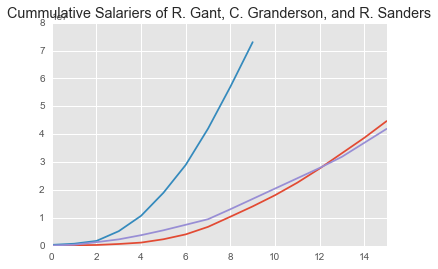

In [115]:
myplot1 = Ron_Gant_df.cummulativeSalary.plot()
myplot2 = Curtis_Granderson_df.cummulativeSalary.plot()
myplot3 = Reggie_Sanders_df.cummulativeSalary.plot(title="Cummulative Salariers of R. Gant, C. Granderson, and R. Sanders")

plt.show()